Dependencies

In [ ]:
!pip install graphviz
!pip install pandas

In [26]:
import graphviz
import pandas as pd
import re
from rolestereotype import RoleStereotype as rs
from collections import Counter
from collections import defaultdict
import classdiagram as cd
import matplotlib.pyplot as plt
import seaborn as sns

The Pattern class (loads .pattern DP-CORE format)

In [2]:
class Pattern:
    abstractionMapping = {
        'Normal': None,
        'Abstract': 'abstract',
        'Interface': 'interface',
        'Abstracted': 'abstracted',
        'Any': None
    }
    def __init__(self, lines):
        idx = 0
        self.name = lines[idx].strip()
        self.members = list()
        self.connections = list()
        idx += 1
        line = lines[idx]
        while line.strip() != 'End_Members':
            line = line.split()
            self.members.append(cd.Member(name=line[0], annot=Pattern.abstractionMapping[line[1]], classname=' '.join(line[2:])))
            idx += 1
            line = lines[idx]
        idx += 1
        line = lines[idx]
        while line.strip() != 'End_Connections':
            line = line.split()
            self.connections.append(cd.Connection(line[1], (line[0], line[2])))
            idx += 1
            line = lines[idx]
    def graph(self):
        dot = cd.graph(self.name, self.members, self.connections)
        return dot



Load pattern descriptions

Note: current best representation of patterns:

- bridge: bridge-v1
- adapter: object-adapter
- factory method: factory-method-v3
- abstract factory: (unknown)

In [3]:
patternNames = [
    'abstract-factory-v1', 
    'abstract-factory-v2',
    'bridge-v1',
    'bridge-v2', 
    'builder', 
    'class-adapter',
    'command', 
    'composite',
    'decorator',
    'factory-method-v1',
    'factory-method-v2',
    'factory-method-v3',
    'object-adapter',
    'observer', 
    'proxy',
    'visitor'
]

patterns = dict()
for name in patternNames:
    file = open(f'pattern-descriptions/{name}.pattern', 'r')
    lines = file.readlines()
    pattern = Pattern(lines)
    file.close()
    patterns[name] = pattern
    graph = pattern.graph()
    print(graph.source)
    # graph.render(outfile=f'pattern-descriptions/graphs/{name}.png')

digraph "Abstract Factory v1" {
	A [label=<{Concrete Factory|}> shape=record]
	B [label=<{«abstracted» Abstract Factory|}> shape=record]
	C [label=<{Product|}> shape=record]
	D [label=<{«abstracted» Abstract Product|}> shape=record]
	B -> A [arrowtail=empty dir=back]
	D -> C [arrowtail=empty dir=back]
	A -> C [arrowtail=diamond dir=back label=creates]
	A -> C [arrowhead=vee label=uses style=dashed]
}

digraph "Abstract Factory v2" {
	A [label=<{Concrete Factory|}> shape=record]
	B [label=<{«abstracted» Abstract Factory|}> shape=record]
	C [label=<{Product|}> shape=record]
	D [label=<{«abstracted» Abstract Product|}> shape=record]
	B -> A [arrowtail=empty dir=back]
	D -> C [arrowtail=empty dir=back]
	A -> C [arrowtail=diamond dir=back label=creates]
	A -> D [arrowhead=vee label=uses style=dashed]
}

digraph "Bridge v1" {
	A [label=<{Refined Abstraction|}> shape=record]
	B [label=<{«abstracted» Abstraction|}> shape=record]
	C [label=<{Concrete Implementor|}> shape=record]
	D [label=<{«ab

Load ground truth data, containing class types (e.g., abstract? interface?) and role stereotypes

In [4]:
gt = pd.read_csv('role-stereotypes.csv')

gt_k9 = gt[gt['case_name'] == 'K-9 Mail']

gt_k9[gt_k9['classname'] == 'AuthType'].iloc[0]

def getGroundTruth(classname, dframe):
    return dframe[dframe['classname'] == classname]

def isInGroundTruth(classname, dframe):
    return getGroundTruth(classname, dframe).shape[0] > 0

def roleStereotype(classname, dframe):
    return rs.from_str(getGroundTruth(classname, dframe).iloc[0]['label']) if isInGroundTruth(classname, dframe) else None

def abstraction(classname, dframe):
    gt = getGroundTruth(classname, dframe)
    if gt.shape[0] == 0:
        return None
    if gt.iloc[0]['isInterface']:
        return 'interface'
    elif gt.iloc[0]['isAbstract']:
        return 'abstract'
    else:
        return 'concrete'

print(isInGroundTruth('AuthType', gt_k9))
print(isInGroundTruth('Hello', gt_k9))

print(roleStereotype('AuthType', gt_k9), abstraction('AuthType', gt_k9))

gt_k9[gt_k9['classname'].str.contains('Builder')]

True
False
Information Holder concrete


,case_name,case_url,version_tag,full_classname,classname,isStaticClass,isInterface,isInnerClass,isClass,isEnum,classPublicity,isAbstract,label
111,K-9 Mail,https://github.com/k9mail/k-9/,5.304,com.fsck.k9.mail.store.imap.UidSearchCommandBu...,UidSearchCommandBuilder,False,False,False,True,False,default,False,Information Holder
146,K-9 Mail,https://github.com/k9mail/k-9/,5.304,com.fsck.k9.mail.internet.MimeMessage$MimeMess...,MimeMessage$MimeMessageBuilder,False,False,True,True,False,private,False,Structurer
304,K-9 Mail,https://github.com/k9mail/k-9/,5.304,com.fsck.k9.search.SqlQueryBuilder,SqlQueryBuilder,False,False,False,True,False,public,False,Service Provider
434,K-9 Mail,https://github.com/k9mail/k-9/,5.304,com.fsck.k9.message.IdentityHeaderBuilder,IdentityHeaderBuilder,False,False,False,True,False,public,False,Service Provider
436,K-9 Mail,https://github.com/k9mail/k-9/,5.304,com.fsck.k9.message.MessageBuilder$Callback,MessageBuilder$Callback,False,True,True,False,False,public,False,Service Provider
437,K-9 Mail,https://github.com/k9mail/k-9/,5.304,com.fsck.k9.message.MessageBuilder,MessageBuilder,False,False,False,True,False,public,True,Service Provider
438,K-9 Mail,https://github.com/k9mail/k-9/,5.304,com.fsck.k9.message.PgpMessageBuilder,PgpMessageBuilder,False,False,False,True,False,public,False,Service Provider
440,K-9 Mail,https://github.com/k9mail/k-9/,5.304,com.fsck.k9.message.SimpleMessageBuilder,SimpleMessageBuilder,False,False,False,True,False,public,False,Service Provider
442,K-9 Mail,https://github.com/k9mail/k-9/,5.304,com.fsck.k9.message.TextBodyBuilder,TextBodyBuilder,False,False,False,True,False,default,False,Service Provider
503,K-9 Mail,https://github.com/k9mail/k-9/,5.304,com.fsck.k9.mailstore.MimePartStreamParser$Par...,MimePartStreamParser$PartBuilder,True,False,True,True,False,private,False,Structurer


Load DP-CORE results on K-9 Mail case

In [5]:
class PatternInstance:
    def __init__(self, pattern: Pattern, mapping):
        self._pattern = pattern
        self._mapping = mapping
        self.members = [mapping[m.name] for m in pattern.members]
        self.name='-'.join(m.name for m in self.members)
        self.connections = [cd.Connection(conn.name, tuple(mapping[p].name for p in conn.participants)) for conn in pattern.connections]
    def graph(self):
        dot = cd.graph(self.name, self.members, self.connections)
        return dot




In [6]:

def cleanup(str):
    return ''.join(c for c in str if c.isalnum())

abstractionMapping = {
    'concrete': None,
    'abstract': 'abstract',
    'interface': 'interface'
}
for name in patternNames:
    pattern = patterns[name]
    file = open(f'k-9/patterns/detect_{name}_pattern_in_k-9-5.304_project.txt', 'r')
    lines = file.readlines()
    amount = int(lines[0].split(':')[-1])
    numMembers = len(pattern.members)
    instances = [[tuple(t.strip() for t in re.split('[\(\):]', s) if t) for s in lines[3 + (i*(2+numMembers)):3 + (i*(2+numMembers))+numMembers]] for i in range(amount)]
    instances = [i for i in instances if all(isInGroundTruth(x[2], gt_k9) for x in i)]
    print(f'{pattern.name}, amount={len(instances)}')
    lst1 = []
    lst2 = defaultdict(list)
    for instance in instances:
        memberMapping = {m[0]:cd.Member(annot=abstractionMapping[abstraction(m[2], gt_k9)], name=cleanup(m[2]), classname=m[2], stereotype=roleStereotype(m[2], gt_k9)) for m in instance}
        # print(f'- {instance}')
        iname = '-'.join(x[2] for x in instance)
        pi = PatternInstance(pattern, memberMapping)
        roles = {cleanup(i[2]):f'{i[1]}:{str(roleStereotype(i[2], gt_k9))}' for i in instance}
        patt1 = ','.join(roles[m.name] for m in pi.members)
        lst1.append(patt1)
        for r in roles:
            p,s = tuple(roles[r].split(':'))
            lst2[p].append(s)
        # graph = pi.graph()
        # print(graph.source)
        # graph.render(outfile=f'k-9/patterns/graphs/{name}/{iname}.png')
        
    print('- pattern instances')
    ctr1 = Counter(lst1)
    for e,c in ctr1.most_common():
        print(f"  - {c}: {e}")

    print('- participants')
    for p in lst2:
        print(f"  - {p}")
        ctr2 = Counter(lst2[p])
        for e,c in ctr2.most_common():
            print(f"    - {c}: {e}")


    file.close()

Abstract Factory v1, amount=1
- pattern instances
  - 1: Concrete Factory:Coordinator,Abstract Factory:Information Holder,Product:Structurer,Abstract Product:Information Holder
- participants
  - Concrete Factory
    - 1: Coordinator
  - Abstract Factory
    - 1: Information Holder
  - Product
    - 1: Structurer
  - Abstract Product
    - 1: Information Holder
Abstract Factory v2, amount=2
- pattern instances
  - 1: Concrete Factory:Service Provider,Abstract Factory:Service Provider,Product:Information Holder,Abstract Product:Service Provider
  - 1: Concrete Factory:Structurer,Abstract Factory:Structurer,Product:Service Provider,Abstract Product:Service Provider
- participants
  - Concrete Factory
    - 1: Service Provider
    - 1: Structurer
  - Abstract Factory
    - 1: Service Provider
    - 1: Structurer
  - Product
    - 1: Information Holder
    - 1: Service Provider
  - Abstract Product
    - 2: Service Provider
Bridge v1, amount=4
- pattern instances
  - 1: Refined Abstraction

Check role stereotype relationships

In [16]:
names = {
    'calls',
    'creates',
    'has',
    'inherits',
    'references',
    'uses'
}

m_g = set()
conn_per_name = dict()
for name in names:
    file = open(f'connection-descriptions/{name}.pattern', 'r')
    lines = file.readlines()
    file.close()
    pattern = Pattern(lines)

    file = open(f'k-9/connections/detect_{name}_pattern_in_k-9-5.304_project.txt', 'r')
    lines = file.readlines()
    file.close()
    amount = int(lines[0].split(':')[-1])
    numMembers = len(pattern.members)
    instances = [[tuple(t.strip() for t in re.split('[\(\):]', s) if t) for s in lines[3 + (i*(2+numMembers)):3 + (i*(2+numMembers))+numMembers]] for i in range(amount)]
    instances = [i for i in instances if all(isInGroundTruth(x[2], gt_k9) for x in i)]
    print(f'{pattern.name}, amount={len(instances)}')

    lst1 = []
    lst2 = []

    members = set()
    connections = list()


    for instance in instances:
        # print(f'- {instance}')
        memberMapping = {m[0]:cd.Member(annot=abstraction(m[2], gt_k9), name=cleanup(m[2]), classname=m[2], stereotype=roleStereotype(m[2], gt_k9)) for m in instance}
        pi = PatternInstance(pattern, memberMapping)
        roles = {cleanup(i[2]):str(roleStereotype(i[2], gt_k9)) for i in instance}
        patt1 = ','.join(f' {c.name} '.join(roles[p] for p in c.participants) for c in pi.connections)
        lst1.append(patt1)
        # lst2.append(patt2) 
        # graph = pi.graph()
        # print(graph.source)
        # graph.render(outfile=f'k-9/patterns/graphs/{name}/{iname}.png')
        members.update(pi.members)
        connections += pi.connections
        
    ctr1 = Counter(lst1)
    # ctr2 = Counter(lst2)

    l = len("Information Holder")
    for e,c in ctr1.most_common():
        ee = e.split(f" {name} ")
        print(f"  {ee[0]:>{l}} {name} {ee[1]:<{l}}: {c}")

    # l = len("interface:Information Holder")
    # for e,c in ctr2.most_common():
    #     ee = e.split(" extends ")
    #     print(f"{ee[0]:>{l}} extends {ee[1]:<{l}}: {c}")

    conn_per_name[name] = connections
    m_g.update(members)


Inherits, amount=115
    Service Provider inherits Service Provider  : 21
          Interfacer inherits Interfacer        : 20
    Service Provider inherits Information Holder: 15
  Information Holder inherits Information Holder: 11
    Service Provider inherits Coordinator       : 6
          Structurer inherits Information Holder: 6
    Service Provider inherits Controller        : 5
    Service Provider inherits Structurer        : 4
    Service Provider inherits Interfacer        : 3
  Information Holder inherits Structurer        : 3
         Coordinator inherits Service Provider  : 2
         Coordinator inherits Coordinator       : 2
  Information Holder inherits Coordinator       : 2
          Interfacer inherits Coordinator       : 2
         Coordinator inherits Information Holder: 2
         Coordinator inherits Interfacer        : 2
          Structurer inherits Controller        : 1
  Information Holder inherits Interfacer        : 1
          Structurer inherits Service P

In [18]:

c_g = list()

for name in names:
    print(name)
    

    prt = [c.participants for c in conn_per_name[name]]
    a,b = tuple(zip(*prt))
    ctra = Counter(a)
    ctrb = Counter(b)
    
    print('  Participant A')
    for e,c in ctra.most_common(5):
        print(f"  -- {e}: {c}")
        
    print('  Participant B')
    for e,c in ctrb.most_common(5):
        print(f"  -- {e}: {c}")

    c_g += conn_per_name[name]

    # g = cd.graph(name, members, connections)
    # g.render(outfile=f'k-9/connections/graphs/{name}.png')



inherits
  Participant A
  -- K9Activity: 13
  -- Body: 8
  -- SizeAware: 6
  -- CoreService: 6
  -- K9ListActivity: 6
  Participant B
  -- FileBackedBody: 3
  -- BinaryMemoryBody: 3
  -- BinaryTempFileMessageBody: 2
  -- TempFileBody: 2
  -- BinaryTempFileBody: 2
uses
  Participant A
  -- LocalStore: 10
  -- WebDavStore: 7
  -- ImapStore: 6
  -- Account: 6
  -- MessagingController: 4
  Participant B
  -- Account: 9
  -- Body: 7
  -- LocalMessage: 7
  -- Part: 7
  -- ServerSettings: 5
calls
  Participant A
  -- MessagingController: 20
  -- MessageCompose: 17
  -- ImapFolder: 16
  -- RecipientPresenter: 12
  -- LocalStore: 11
  Participant B
  -- Account: 58
  -- Message: 22
  -- Part: 18
  -- MessageReference: 15
  -- Storage: 14
references
  Participant A
  -- MessagingController: 18
  -- ImapFolder: 13
  -- RecipientPresenter: 12
  -- MessageBuilder: 11
  -- LocalFolder: 10
  Participant B
  -- Account: 52
  -- Message: 41
  -- Part: 32
  -- MessageReference: 17
  -- ImapResponse: 15

In [19]:
print('# MEMBERS #########################################################################################')
for m in m_g:
    print(f'{m.classname},{m.annot},{str(m.stereotype)}')
print('# CONNECTIONS #####################################################################################')
for c in c_g:
    print(f'{c.name},{c.participants[0]},{c.participants[1]}')

# MEMBERS #########################################################################################
Account,concrete,Information Holder
Message,abstract,Structurer
WearNotifications,concrete,Coordinator
MimeHeader,concrete,Structurer
LocalFolder,concrete,Information Holder
MessageReference,concrete,Information Holder
Storage,concrete,Structurer
Body,interface,Service Provider
StoreConfig,interface,Information Holder
MessageCryptoPresenter,concrete,Controller
DecoderUtil,concrete,Service Provider
Account,concrete,Information Holder
NotificationController,concrete,Controller
NotificationActionCreator,concrete,Service Provider
Part,interface,Service Provider
Account,concrete,Information Holder
MessagingController,concrete,Controller
Account,concrete,Information Holder
MimeBodyPart,concrete,Structurer
FolderInfoHolder,concrete,Information Holder
NotificationContent,concrete,Information Holder
WearNotifications,concrete,Coordinator
Message,abstract,Structurer
Message,abstract,Structurer
Mim

In [20]:
m_map = {m.name:m for m in m_g}
m_map


{'Account': <classdiagram.Member at 0x2434e8ff4f0>,
 'Message': <classdiagram.Member at 0x2434e5ffca0>,
 'WearNotifications': <classdiagram.Member at 0x2434e73e700>,
 'MimeHeader': <classdiagram.Member at 0x2434eb3bf70>,
 'LocalFolder': <classdiagram.Member at 0x2434eafc8b0>,
 'MessageReference': <classdiagram.Member at 0x2434e5fff10>,
 'Storage': <classdiagram.Member at 0x2434e9fb640>,
 'Body': <classdiagram.Member at 0x2434e63fbe0>,
 'StoreConfig': <classdiagram.Member at 0x2434e87b310>,
 'MessageCryptoPresenter': <classdiagram.Member at 0x2434e63ff10>,
 'DecoderUtil': <classdiagram.Member at 0x2434eb28490>,
 'NotificationController': <classdiagram.Member at 0x2434e8ff610>,
 'NotificationActionCreator': <classdiagram.Member at 0x2434e5ffee0>,
 'Part': <classdiagram.Member at 0x2434e5bf310>,
 'MessagingController': <classdiagram.Member at 0x2434eafcf40>,
 'MimeBodyPart': <classdiagram.Member at 0x2434e63f4c0>,
 'FolderInfoHolder': <classdiagram.Member at 0x2434ebb81c0>,
 'Notification

In [42]:
for name in names:
    # print(f'* {name.title()}')
    focus = [(rs.SERVICE_PROVIDER, rs.INFORMATION_HOLDER),
        (rs.INFORMATION_HOLDER, rs.SERVICE_PROVIDER)]
    for (f1,f2) in focus:
        # print(f'    * {f1} {name} {f2}')
        ls = []
        for conn in conn_per_name[name]:
            if (m_map[conn.participants[0]].stereotype == f1 
                    and m_map[conn.participants[1]].stereotype == f2):
                ls.append(f'{name},{conn.participants[0]},{f1},{conn.participants[1]},{f2}')
                # ls.append(f'        * {conn.participants[0]} {name} {conn.participants[1]}')
        ls.sort()
        for l in ls:
            print(l)

* Inherits
    * Service Provider inherits Information Holder
        * BinaryAttachmentBody inherits TempFileBody
        * Body inherits BinaryMemoryBody
        * Body inherits BinaryTempFileMessageBody
        * Body inherits FileBackedBody
        * Body inherits TextBody
        * MergeCursor inherits MergeCursorWithUniqueId
        * Part inherits BodyPart
        * RawDataBody inherits BinaryMemoryBody
        * RawDataBody inherits BinaryTempFileBody
        * RawDataBody inherits FileBackedBody
        * SizeAware inherits BinaryMemoryBody
        * SizeAware inherits BinaryTempFileBody
        * SizeAware inherits FileBackedBody
        * SizeAware inherits TempFileBody
        * SizeAware inherits TextBody
    * Information Holder inherits Service Provider
        * Store inherits LocalStore
* Uses
    * Service Provider uses Information Holder
        * AttachmentContentLoader uses Attachment
        * AttachmentInfoExtractor uses AttachmentViewInfo
        * AttachmentInf

In [22]:

conn_mat = {name: [[len([conn for conn in conn_per_name[name] if m_map[conn.participants[0]].stereotype == a and m_map[conn.participants[1]].stereotype == b]) for b in rs] for a in rs] for name in names}
conn_mat

{'inherits': [[0, 0, 0, 0, 0, 0],
  [0, 2, 2, 2, 2, 1],
  [0, 2, 11, 1, 1, 3],
  [1, 2, 0, 20, 1, 0],
  [5, 6, 15, 3, 21, 4],
  [1, 1, 6, 0, 1, 1]],
 'uses': [[0, 0, 4, 0, 2, 1],
  [1, 0, 3, 0, 1, 4],
  [0, 1, 23, 0, 5, 5],
  [1, 2, 10, 1, 2, 1],
  [1, 1, 30, 0, 21, 8],
  [0, 0, 14, 0, 8, 9]],
 'calls': [[4, 9, 22, 5, 19, 21],
  [11, 5, 22, 2, 23, 16],
  [1, 0, 12, 0, 7, 5],
  [7, 9, 30, 15, 12, 10],
  [6, 12, 73, 1, 78, 63],
  [1, 0, 13, 1, 14, 16]],
 'references': [[3, 3, 25, 4, 13, 11],
  [9, 4, 23, 1, 21, 13],
  [0, 0, 33, 0, 14, 15],
  [3, 2, 40, 7, 9, 4],
  [2, 10, 86, 1, 62, 61],
  [1, 0, 21, 1, 19, 14]],
 'creates': [[1, 7, 5, 2, 11, 4],
  [0, 3, 3, 0, 10, 4],
  [1, 1, 11, 0, 4, 2],
  [1, 1, 7, 7, 7, 0],
  [1, 5, 41, 2, 41, 14],
  [0, 1, 10, 0, 8, 10]],
 'has': [[4, 10, 37, 7, 30, 25],
  [12, 7, 42, 2, 27, 18],
  [1, 0, 42, 0, 16, 10],
  [8, 11, 69, 25, 21, 11],
  [6, 17, 160, 1, 119, 96],
  [1, 0, 31, 1, 25, 21]]}

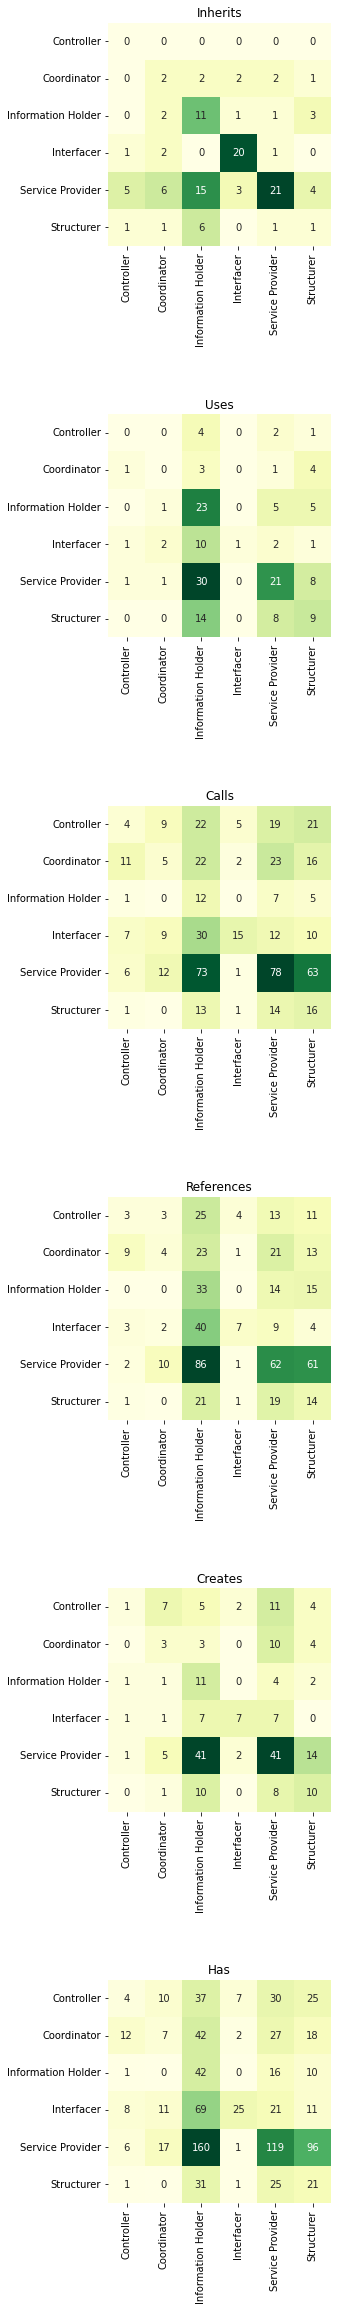

In [36]:
plt.figure(0, figsize=(4,42))

idx = 610
for k,v in conn_mat.items():
    idx += 1
    ax = plt.subplot(idx)
    ax.set_title(k.title())
    sns.heatmap(data= v, ax= ax,
        xticklabels= rs,
        yticklabels= rs,
        annot=True, 
        fmt='d', 
        cmap='YlGn', 
        # linewidths=1, 
        # linecolor='black',
        cbar=False, 
        square=True,)